<a href="https://colab.research.google.com/github/darkxaze/Machinelearnning-courseworkprojects/blob/main/CNNbase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a simple pathology image dataset.

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance. 

To change the dataset that will download just change the variable DATA_NAME to desired dataset name.

All storage on a Google Colab instance is deleted when the instance ends so the dataset will need to be redownloaded each time an instance is created (Don't worry this usually takes about 20 seconds).

In [4]:
DATA_NAME = "PathMNIST"

In [5]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2022-04-05 23:44:02--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22843 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0s      

2022-04-05 23:44:03 (74.9 MB/s) - ‘info.py’ saved [22843/22843]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

205627392/205615438 [==============================] - 4s 0us/step


In [7]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

In [8]:
print(len(train_x))
print(len(val_x))

89996
10004


## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [9]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

                                      Train    Val  Test
adipose                                9366   1041  1338
background                             9509   1057   847
debris                                10360   1152   339
lymphocytes                           10401   1156   634
mucus                                  8006    890  1035
smooth muscle                         12182   1354   592
normal colon mucosa                    7886    877   741
cancer-associated stroma               9401   1045   421
colorectal adenocarcinoma epithelium  12885   1432  1233
total                                 89996  10004  7180


40649: colorectal adenocarcinoma epithelium


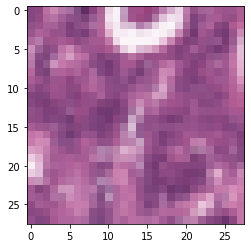

In [10]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
#plt.imshow(train_x[random.randint(0, len(train_x))])
plt.imshow(train_x[index])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [11]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True)

In [12]:
data_generator.fit(np.append(train_x, val_x, 0))

In [13]:
print(len(train_x))
print(len(val_x))

89996
10004


## Model Definition
In this section we will define the neural network arcitecture.

In [14]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

#dense layer
dense1 =  layers.Dense(units=500, activation="relu")(flatten)
dense2 =  layers.Dense(units=200, activation="relu")(dense1)
dense3 =  layers.Dense(units=50, activation="relu")(dense2)
# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(dense3)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0     

## Model Training
This is where we define the training options and then train the model.


In [15]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

In [16]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/30
1406/1406 [==============================] - 25s 11ms/step - loss: 1.9367 - accuracy: 0.3077 - val_loss: 1.7083 - val_accuracy: 0.3928
Epoch 2/30
1406/1406 [==============================] - 16s 11ms/step - loss: 1.5841 - accuracy: 0.4249 - val_loss: 1.5023 - val_accuracy: 0.4361
Epoch 3/30
1406/1406 [==============================] - 16s 12ms/step - loss: 1.4328 - accuracy: 0.4623 - val_loss: 1.3725 - val_accuracy: 0.4848
Epoch 4/30
1406/1406 [==============================] - 16s 11ms/step - loss: 1.3461 - accuracy: 0.4912 - val_loss: 1.3877 - val_accuracy: 0.4618
Epoch 5/30
1406/1406 [==============================] - 16s 11ms/step - loss: 1.2867 - accuracy: 0.5146 - val_loss: 1.2732 - val_accuracy: 0.5110
Epoch 6/30
1406/1406 [==============================] - 16s 11ms/step - loss: 1.2311 - accuracy: 0.5360 - val_loss: 1.2107 - val_accuracy: 0.5576
Epoch 7/30
1406/1406 [==============================] - 16s 11ms/step - loss: 1.1854 - accuracy: 0.5560 - val_loss: 1.1784 -

## Plot Learning Curves
This is where we visualise the training of the model.

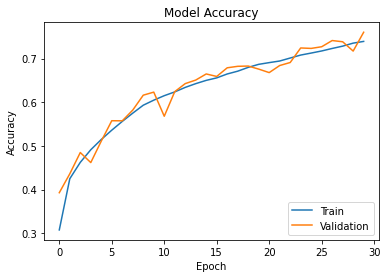

In [18]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

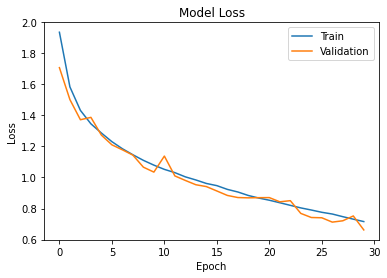

In [19]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [20]:
score = model.evaluate(test_x, to_categorical(test_y), verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1093.4854736328125
Test accuracy: 0.07980501651763916


In [25]:
score = model.evaluate(data_generator.flow(test_x, to_categorical(test_y), verbose = 0)) 

#print('Test loss:', score[0]) 
#print('Test accuracy:', score[1])

TypeError: ignored

In [22]:
'''test_generator = test_datagen.flow_from_directory(
        "test",
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)'''

'test_generator = test_datagen.flow_from_directory(\n        "test",\n        target_size=(150, 150),\n        batch_size=20,\n        class_mode=\'binary\')\n\ntest_loss, test_acc = model.evaluate(test_generator)\nprint(\'test acc:\', test_acc)'